In [1]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments
from sklearn.metrics import classification_report
import numpy as np
from EntityRecognition import *
import torch.optim as optim

model_name = 'klue/bert-base'
num_labels = 7
label_names = ['Other', 'B-store', 'I-store', 'B-menu', 'I-menu', 'B-count', 'I-count']

# json 파일의 tokens와 ner_tags의 길이가 같은지 확인
import pandas as pd 
a = pd.read_json('total_train_tag.json')
for i, j in zip(a['tokens'], a['ner_tags']):
    if len(i) == len(j):
        pass
    else:
        print(False)
        print(i)
        print(j)

# 학습

In [2]:
ner = NERTrainer(model_name, num_labels, label_names)

lr = 1e-5
weight_decay = 0.001
# optimizer = optim.AdamW(ner.model.parameters(), lr=lr)
optimizer = optim.SGD(ner.model.parameters(), lr=lr)

new_dataset = ner.make_new_dataset('total_train_tag.json')
split_dataset = ner.split_training(new_dataset, optimizer, weight_decay = weight_decay, test_size=0.1, batch_size=32, epoch=10)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 2.209392547607422, 'eval_f1': 0.04691295601443298, 'eval_accuracy': 0.03586647727272727, 'eval_runtime': 1.8664, 'eval_samples_per_second': 35.362, 'eval_steps_per_second': 1.607, 'epoch': 1.0}


KeyboardInterrupt: 

# 평가 지표

In [18]:
report = ner.evaluate(split_dataset['test'])
print(report)

  0%|          | 0/66 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       Other       0.98      0.97      0.97      2278
     B-store       0.92      0.83      0.87        70
     I-store       0.95      0.88      0.92       288
      B-menu       0.83      0.90      0.86       112
      I-menu       0.79      0.91      0.85       348
     B-count       0.92      0.87      0.89        92
     I-count       0.97      0.79      0.87       112

    accuracy                           0.94      3300
   macro avg       0.91      0.88      0.89      3300
weighted avg       0.95      0.94      0.94      3300



# 테스트 데이터 추론

In [31]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from sklearn.metrics import *

model_name = 'klue/bert-base'
num_labels = 7
label_names = ['Other', 'B-store', 'I-store', 'B-menu', 'I-menu', 'B-count', 'I-count']

model_path = './total_model/lr(1e-3)wd(0.001)ot(SGD)/model'
tokenizer_path = './total_model/lr(1e-3)wd(0.001)ot(SGD)/tokenizer'

model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

test_tag = pd.read_json('total_test_tag.json')

tokens = test_tag['tokens']
ner_tags = test_tag['ner_tags']

In [30]:
total_pred_list = []
total_target_list = []

for token, ner_tag in zip(tokens, ner_tags):
    tokenized_inputs = tokenizer(token, truncation=True, is_split_into_words=True, return_tensors='pt')

    with torch.no_grad():
        output = model(
            input_ids = tokenized_inputs['input_ids'],
            token_type_ids = tokenized_inputs['token_type_ids'],
            attention_mask = tokenized_inputs['attention_mask']
        )

    pred = output.logits
    pred_list = pred.argmax(dim=2).squeeze().tolist()[1:-1]

    total_pred_list.extend(pred_list)
    total_target_list.extend(ner_tag)

accuracy = accuracy_score(total_target_list, total_pred_list)
f1 = f1_score(total_target_list, total_pred_list, average='weighted')
mse = mean_squared_error(total_target_list, total_pred_list)

print(f"accuracy : {accuracy}")
print(f"f1_score : {f1}")
print(f"mse : {mse}")

accuracy : 0.8775645268034414
f1_score : 0.8772444240886543
mse : 1.229649238914626


# CSV 파일 만들기

In [40]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# import torch
# from sklearn.metrics import *

# learning_rate = ['1e-5', '1e-4', '1e-3']
# weight_decay = [0.001, 0.01]
# optimizer = ['AdamW', 'SGD']

# for lr in learning_rate:
#     for wd in weight_decay:
#         for op in optimizer:
#             model_name = 'klue/bert-base'
#             num_labels = 7
#             label_names = ['Other', 'B-store', 'I-store', 'B-menu', 'I-menu', 'B-count', 'I-count']

#             model_path = f'./total_model/lr({lr})wd({wd})ot({op})/model'
#             tokenizer_path = f'./total_model/lr({lr})wd({wd})ot({op})/tokenizer'

#             model = AutoModelForTokenClassification.from_pretrained(model_path)
#             tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

#             test_tag = pd.read_json('total_test_tag.json')

#             tokens = test_tag['tokens']
#             ner_tags = test_tag['ner_tags']

#             total_pred_list = []
#             total_target_list = []

#             for token, ner_tag in zip(tokens, ner_tags):
#                 tokenized_inputs = tokenizer(token, truncation=True, is_split_into_words=True, return_tensors='pt')

#                 with torch.no_grad():
#                     output = model(
#                         input_ids = tokenized_inputs['input_ids'],
#                         token_type_ids = tokenized_inputs['token_type_ids'],
#                         attention_mask = tokenized_inputs['attention_mask']
#                     )

#                 pred = output.logits
#                 pred_list = pred.argmax(dim=2).squeeze().tolist()[1:-1]

#                 total_pred_list.extend(pred_list)
#                 total_target_list.extend(ner_tag)

#             accuracy = accuracy_score(total_target_list, total_pred_list)
#             f1 = f1_score(total_target_list, total_pred_list, average='weighted')
#             mse = mean_squared_error(total_target_list, total_pred_list)

#             with open('result.csv', mode='a') as f:
#                 f.write(f"\n{op},{lr},{wd},{round(accuracy,4)},{round(f1,4)},{round(mse,4)}")

# 시각화

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

result = pd.read_csv('result.csv')
result

,Optimizer,Learning Rate,Weight Decay,Accuracy,F1-Score,MSE
0,AdamW,0.00001,0.001,0.9385,0.9386,0.5334
1,SGD,0.00001,0.001,0.1516,0.1616,8.8034
2,AdamW,0.00001,0.010,0.9404,0.9406,0.4950
3,SGD,0.00001,0.010,0.2310,0.2166,7.7386
4,AdamW,0.00010,0.001,0.9305,0.9305,0.5884
5,SGD,0.00010,0.001,0.3521,0.2800,8.2045
6,AdamW,0.00010,0.010,0.8968,0.8971,1.0311
7,SGD,0.00010,0.010,0.3521,0.2800,8.2045
8,AdamW,0.00100,0.001,0.2674,0.1128,10.1463
9,SGD,0.00100,0.001,0.8776,0.8772,1.2296


In [105]:
result.corr(numeric_only=True)

,Learning Rate,Weight Decay,Accuracy,F1-Score,MSE
Learning Rate,1.000000e+00,7.018411e-17,-0.030146,-0.106705,0.142045
Weight Decay,7.018411e-17,1.000000e+00,0.013221,0.006347,-0.014594
Accuracy,-3.014609e-02,1.322135e-02,1.000000,0.991523,-0.978927
F1-Score,-1.067054e-01,6.347358e-03,0.991523,1.000000,-0.996474
MSE,1.420448e-01,-1.459369e-02,-0.978927,-0.996474,1.000000


In [102]:
adamw = result[result['Optimizer'] == 'AdamW']
sgd = result[result['Optimizer'] == 'SGD']
adamw

,Optimizer,Learning Rate,Weight Decay,Accuracy,F1-Score,MSE
0,AdamW,0.00001,0.001,0.9385,0.9386,0.5334
2,AdamW,0.00001,0.010,0.9404,0.9406,0.4950
4,AdamW,0.00010,0.001,0.9305,0.9305,0.5884
6,AdamW,0.00010,0.010,0.8968,0.8971,1.0311
8,AdamW,0.00100,0.001,0.2674,0.1128,10.1463
10,AdamW,0.00100,0.010,0.2674,0.1128,10.1463


In [103]:
sgd

,Optimizer,Learning Rate,Weight Decay,Accuracy,F1-Score,MSE
1,SGD,0.00001,0.001,0.1516,0.1616,8.8034
3,SGD,0.00001,0.010,0.2310,0.2166,7.7386
5,SGD,0.00010,0.001,0.3521,0.2800,8.2045
7,SGD,0.00010,0.010,0.3521,0.2800,8.2045
9,SGD,0.00100,0.001,0.8776,0.8772,1.2296
11,SGD,0.00100,0.010,0.8815,0.8812,1.1760


비교적 Optimizer와 Learning Rate에 따른 성능 차이는 보였지만 Weight Decay에 따른 성능 차이는 미미했다.

### 성능에 가장 크게 영향을 준 Optimizer와 Learning Rate에 따른 성능 차이를 시각화

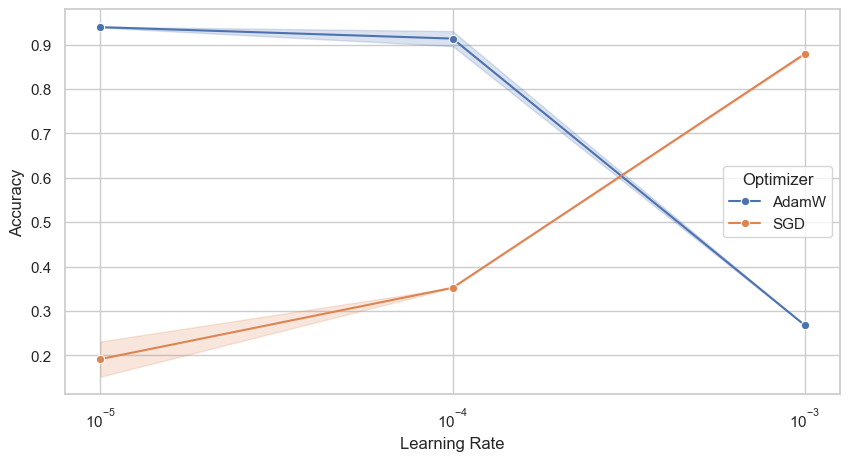

In [68]:
# Optimizer와 Learning Rate에 따른 Accuracy 비교
plt.figure(figsize=(10,5))
sns.lineplot(data=result, x="Learning Rate", y='Accuracy', hue="Optimizer", marker='o')
plt.xscale('log')
plt.show()

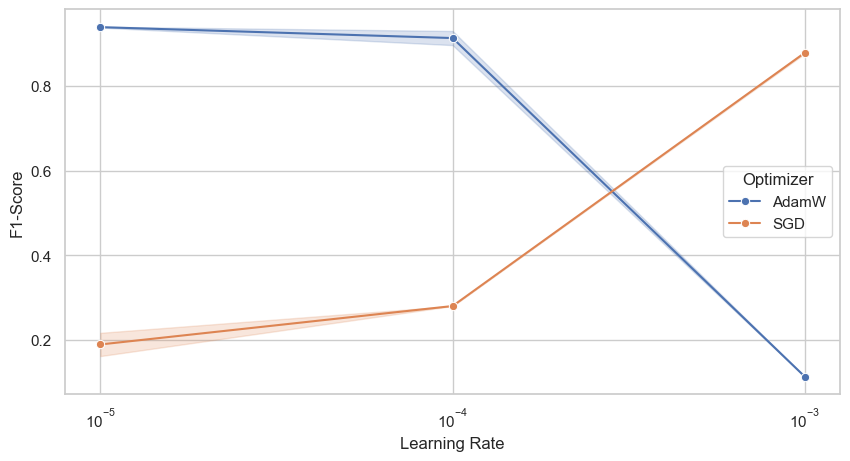

In [64]:
# Optimizer와 Learning Rate에 따른 F1-Score 비교
plt.figure(figsize=(10,5))
sns.lineplot(data=result, x="Learning Rate", y='F1-Score', hue="Optimizer", marker='o')
plt.xscale('log')
plt.show()

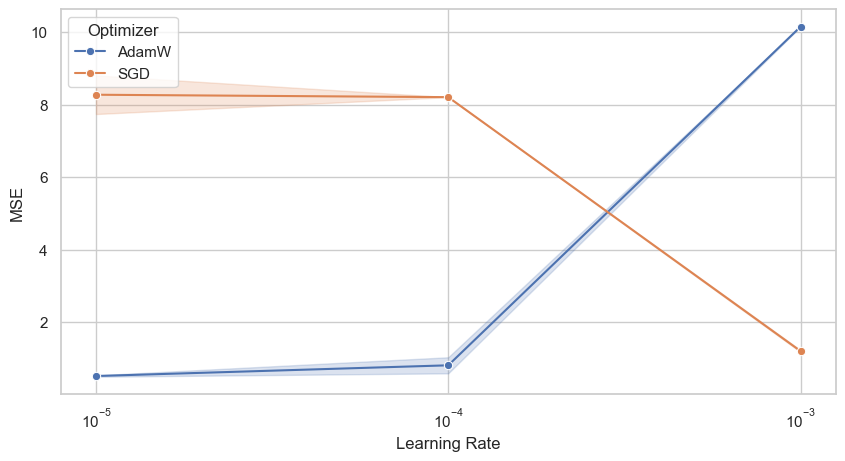

In [69]:
# Optimizer와 Learning Rate에 따른 MSE 비교
plt.figure(figsize=(10,5))
sns.lineplot(data=result, x="Learning Rate", y='MSE', hue="Optimizer", marker='o')
plt.xscale('log')
plt.show()

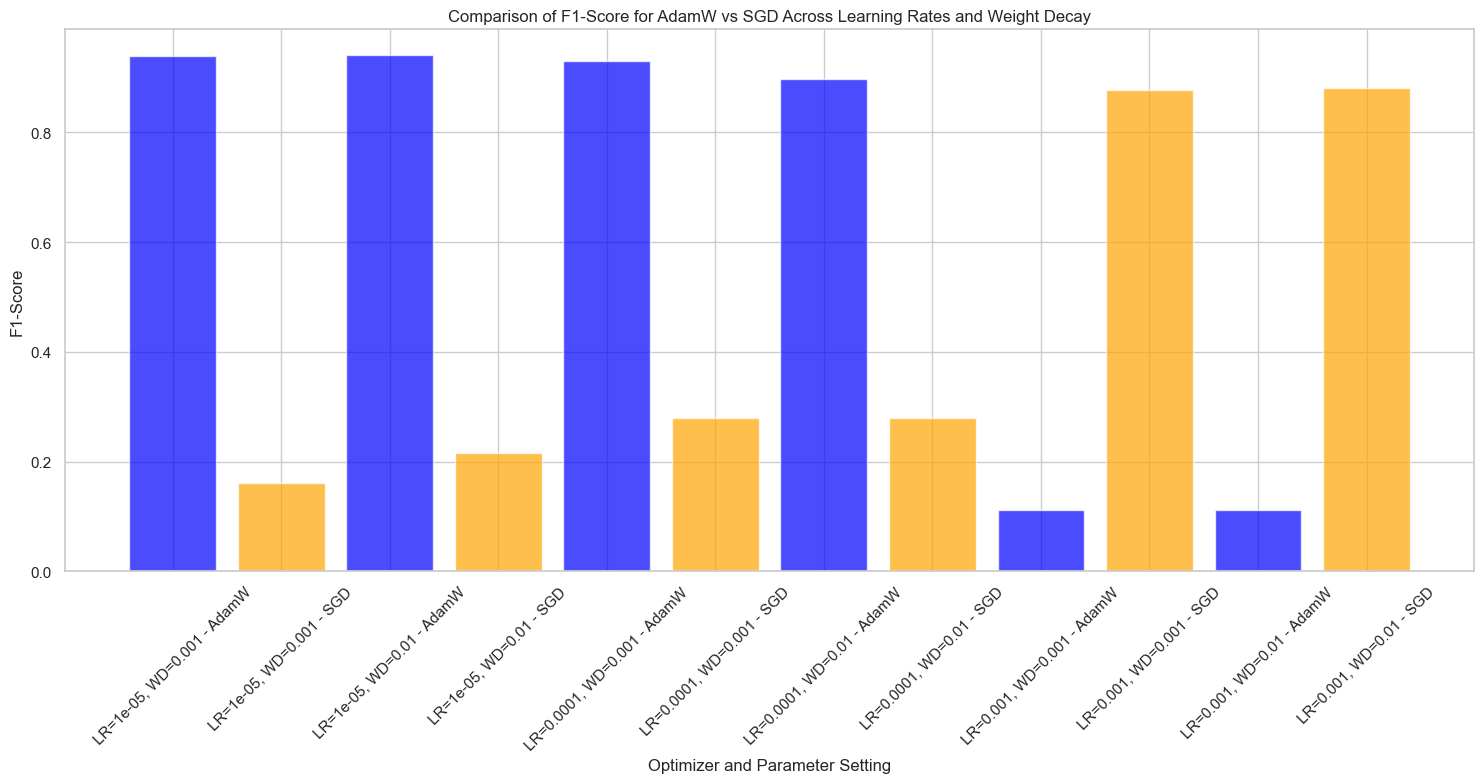

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 준비
data = pd.DataFrame({
    "Optimizer": ["AdamW", "SGD", "AdamW", "SGD", "AdamW", "SGD", "AdamW", "SGD", "AdamW", "SGD", "AdamW", "SGD"],
    "Learning Rate": [0.00001, 0.00001, 0.00001, 0.00001, 0.0001, 0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.001],
    "Weight Decay": [0.001, 0.001, 0.01, 0.01, 0.001, 0.001, 0.01, 0.01, 0.001, 0.001, 0.01, 0.01],
    "F1-Score": [0.9386, 0.1616, 0.9406, 0.2166, 0.9305, 0.2800, 0.8971, 0.2800, 0.1128, 0.8772, 0.1128, 0.8812]
})

# 그래프 스타일 설정
plt.figure(figsize=(15, 8))

# 각 조합에 대해 막대그래프를 그리기
for idx, (learning_rate, weight_decay) in enumerate(zip(
    [0.00001, 0.00001, 0.0001, 0.0001, 0.001, 0.001], 
    [0.001, 0.01, 0.001, 0.01, 0.001, 0.01]
)):
    # 조건에 맞는 데이터 추출
    df_group = data[
        (data["Learning Rate"] == learning_rate) & 
        (data["Weight Decay"] == weight_decay)
    ]
    
    # AdamW와 SGD의 F1-Score 추출
    adamw_f1 = df_group[df_group["Optimizer"] == "AdamW"]["F1-Score"].values[0]
    sgd_f1 = df_group[df_group["Optimizer"] == "SGD"]["F1-Score"].values[0]
    
    # 막대 그래프 그리기
    plt.bar(
        x=[f'LR={learning_rate}, WD={weight_decay} - AdamW', f'LR={learning_rate}, WD={weight_decay} - SGD'],
        height=[adamw_f1, sgd_f1],
        color=['blue', 'orange'],
        alpha=0.7
    )
    plt.xticks(rotation=45)

# 그래프 타이틀 및 축 라벨 설정
plt.title("Comparison of F1-Score for AdamW vs SGD Across Learning Rates and Weight Decay")
plt.ylabel("F1-Score")
plt.xlabel("Optimizer and Parameter Setting")
plt.tight_layout()
plt.show()


1. 결론 요약:
    1. 가장 높은 성능
        - 최고 성능은 Optimizer : AdamW, Learning Rate : 1e-5, Weight Decay = 0.01일 때 기록 됨
            - Accuracy : 0.9404
            - F1-Score : 0.9406
            - Mean Squared Error : 0.495
    2. Optimizer의 경향성
        - AdamW는 전반적으로 높은 성능을 보였고 안정적이었다
        - SGD는 높은 Learning Rate(1e-3)에서만 상대적으로 높은 성능을 보였으나 낮은 Learning Rate(1e-5, 1e-4)에서는 성능이 매우 낮았다
    3. Learning Rate의 영향
        - 낮은 Learning Rate(1e-5)가 안정적이고 높은 성능을 기록했다
        - 높은 Learning Rate(1e-3)에서는 AdamW의 성능이 급격하게 하락했으나 SGD는 상대적으로 좋은 성능을 기록했다
    4. Weight Decay의 영향
        - Weight Decay가 0.01일 때 전반적으로 성능이 더 높았다
        - 지나치게 작은 Weight Decay(0.001)는 과적합 방지에 덜 효과적이었다

2. 발표 예시
    - 이번 분석에서는 Optimizer, Learning Rate, Weight Decay의 조합에 따른 성능 변화를 비교하였다
    - 최고 성능은 AdamW, Learning Rate=1e-5, Weight Decay=0.01에서 기록되었다. (F1-Score=0.9406)
    - AdamW는 안정적이고 높은 성능을 보였으며 SGD는 낮은 Learning Rate에서 성능이 낮고 높은 Learning Rate에서 좋은 성능을 보였다
    - 

3. 문제점 및 개선 방안
    - 실제로 학습한 모델로 추론 결과 메뉴명이 길거나 문장형이면 잘 추출하지 못하는 것을 확인하였다
        - RAG 기법과 메뉴 DB 연동을 통해 추론한 메뉴가 메뉴 DB에 포함
    - 또한, 수량이 10개가 넘어가면 일의 자리 수량만 추출하는 현상도 확인하였다
        - 수량이 10개 이상인 주문 데이터를 추가로 학습시키면 해결될 것으로 생각된다

# 추론

In [34]:
test_pred = ner.pred_object(split_dataset['test'])

  0%|          | 0/43 [00:00<?, ?it/s]

In [35]:
test_dataset = split_dataset['test']
predictions, label_ids, metrics = ner.trainer.predict(test_dataset)

preds = np.argmax(predictions, axis=2)
tokens = test_dataset['tokens']
tokenized_inputs = ner.tokenizer(tokens, is_split_into_words=True, truncation=True)
input_ids = tokenized_inputs['input_ids']
decode_tokens_list = []
for i in input_ids:
    decode_tokens = ner.tokenizer.convert_ids_to_tokens(i) # 인덱스 숫자 값을 다시 단어로 디코딩
    decode_tokens_list.append(decode_tokens)

  0%|          | 0/43 [00:00<?, ?it/s]

In [38]:
def predict_entity(decode_token, pred):
    STORE, FOOD, COUNT = [], [], []
    for i in range(len(pred)):
        if pred[i] == 1: STORE.append(decode_token[i])
        elif pred[i] == 2: STORE[-1] += decode_token[i]
        elif pred[i] == 3: FOOD.append(decode_token[i])
        elif pred[i] == 4: FOOD[-1] += decode_token[i]
        elif pred[i] == 5: COUNT.append(decode_token[i])
        elif pred[i] == 6: COUNT[-1] += decode_token[i]

    linear_text = ''.join(decode_token[1:-1])

    food_start_index, count_start_index, min_index_list = [], [], []
    for i in FOOD: food_start_index.append(linear_text.find(i))
    for i in COUNT: count_start_index.append(linear_text.find(i))
    for i in count_start_index:
        diff_index = [i-j if i-j > 0 else 999 for j in food_start_index]
        min_index = np.argmin(diff_index)
        min_index_list.append(min_index)
    min_index_list
    new_count_list = ['X'] * len(FOOD)
    for i, j in zip(COUNT, min_index_list): new_count_list[j] = i
    
    from konlpy.tag import Mecab
    dicpath = '/opt/homebrew/lib/mecab/dic/mecab-ko-dic'
    mecab = Mecab(dicpath + " -r /opt/homebrew/etc/mecabrc")

    new_store, new_food, new_count = [], [], []
    for i in STORE: new_store.append(' '.join(mecab.morphs(i)))
    for i in FOOD: new_food.append(' '.join(mecab.morphs(i)))
    for i in new_count_list: new_count.append(' '.join(mecab.morphs(i)))

    return new_store, new_food, new_count

index = 0
decode_token = decode_tokens_list[index]
pred = preds[index]
store, food, count = predict_entity(decode_token, pred)

print(f'매장명 : {store}')
print(f'음식명 : {food}')
print(f'수량 : {count}')

매장명 : ['일 미리 금계 찜 닭']
음식명 : ['닭볶음탕 중자', '떡 사리']
수량 : ['하나', 'X']


In [39]:
def predict_text(test_text):
    test_token = [i for i in test_text.replace(' ', '')]
    tokenized_inputs = ner.tokenizer(test_token, truncation=True, is_split_into_words=True)
    data = {
        'input_ids' : [tokenized_inputs['input_ids']],
        'token_type_ids' : [tokenized_inputs['token_type_ids']],
        'attention_mask' : [tokenized_inputs['attention_mask']]
    }
    input_dataset = Dataset.from_dict(data)
    predictions, label_ids, metrics = ner.trainer.predict(input_dataset)

    pred = np.argmax(predictions, axis=2)[0]
    decode_tokens = [ner.tokenizer.convert_ids_to_tokens(i) for i in tokenized_inputs['input_ids']]

    TOTAL_STORE, TOTAL_FOOD, TOTAL_COUNT = '', '', ''

    zip_list = [i for i in zip(decode_tokens, pred) if i[1] != 0]
    for i in range(len(zip_list)):
        if i != len(zip_list) - 1:
            if (zip_list[i][1] == 1) or (zip_list[i][1] == 2 and zip_list[i+1][1] == 2):
                TOTAL_STORE += zip_list[i][0]
            elif zip_list[i][1] == 2 and zip_list[i+1][1] != 2:
                TOTAL_STORE += (zip_list[i][0] + ', ')
            if (zip_list[i][1] == 3) or (zip_list[i][1] == 4 and zip_list[i+1][1] == 4):
                TOTAL_FOOD += zip_list[i][0]
            elif zip_list[i][1] == 4 and zip_list[i+1][1] != 4:
                TOTAL_FOOD += (zip_list[i][0] + ', ')
            if (zip_list[i][1] == 5) or (zip_list[i][1] == 6 and zip_list[i+1][1] == 6):
                TOTAL_COUNT += zip_list[i][0]
            elif zip_list[i][1] == 6 and zip_list[i+1][1] != 6:
                TOTAL_COUNT += (zip_list[i][0] + ', ')
        else:
            if zip_list[i][1] == 1 or zip_list[i][1] == 2:
                TOTAL_STORE += (zip_list[i][0] + ', ')
            elif zip_list[i][1] == 3 or zip_list[i][1] == 4:
                TOTAL_FOOD += (zip_list[i][0] + ', ')
            elif zip_list[i][1] == 5 or zip_list[i][1] == 6:
                TOTAL_COUNT += (zip_list[i][0] + ', ')

    FINAL_STORE = TOTAL_STORE[:-2]
    FINAL_FOOD = TOTAL_FOOD[:-2]
    FINAL_COUNT = TOTAL_COUNT[:-2]

    from konlpy.tag import Mecab

    dicpath = '/opt/homebrew/lib/mecab/dic/mecab-ko-dic'
    mecab = Mecab(dicpath + " -r /opt/homebrew/etc/mecabrc")

    store_list = FINAL_STORE.split(', ')
    food_list = FINAL_FOOD.split(', ')
    count_list = FINAL_COUNT.split(', ')

    new_store_list, new_food_list, new_count_list = [], [], []
    for i in store_list:
        mecab_token = ' '.join(mecab.morphs(i))
        new_store_list.append(mecab_token)
    for i in food_list:
        mecab_token = ' '.join(mecab.morphs(i))
        new_food_list.append(mecab_token)
    for i in count_list:
        mecab_token = ' '.join(mecab.morphs(i))
        new_count_list.append(mecab_token)
    
    linear_text = test_text.replace(' ', '')
    food_start_index = []
    count_start_index = []
    count_index = []

    for i in new_food_list:
        linear_food = i.replace(' ', '')
        food_start_index.append(linear_text.find(linear_food))

    for i in new_count_list:
        linear_count = i.replace(' ', '')
        count_start_index.append(linear_text.find(linear_count))

    for i in count_start_index:
        distance_list = [i-j for j in food_start_index]
        plus_distance_list = [i if i > 0 else 9999 for i in distance_list]
        min_value = min(plus_distance_list)
        min_index = plus_distance_list.index(min_value)
        count_index.append(min_index)

    match_count = ['없음'] * len(new_food_list)
    for index, i in enumerate(count_index):
        match_count[i] = new_count_list[index]

    return new_store_list, new_food_list, match_count

In [40]:
test_text = 'BBQ에서 후라이드 양념 2마리씩 시킬게요'
store, food, count = predict_text(test_text)

print(f'원문 : {test_text}')
print(f'매장명 : {store}')
print(f'음식명 : {food}')
print(f'수량 : {count}')

  0%|          | 0/1 [00:00<?, ?it/s]

원문 : BBQ에서 후라이드 양념 2마리씩 시킬게요
매장명 : ['BBQ']
음식명 : ['후라이드', '양념']
수량 : ['없음', '2 마리 씩']


# 성윤님 데이터 옮기기

In [348]:
def insert_token_to_json(test_text, ner_string, json_name):
    tokens = [i for i in test_text if i != ' ']
    string_tokens = str(tokens).replace("'", '"')
    ner_tags = [int(i) for i in ner_string]
    with open(json_name, mode='r', encoding='utf-8') as f:
        file = f.read()[:-2]

    with open(json_name, mode='w', encoding='utf-8') as f:
        f.write(file)
        f.write(',\n')
        f.write('    {\n')
        f.write(f'        "tokens" : {string_tokens},\n')
        f.write(f'        "ner_tags" : {ner_tags}\n')
        f.write('    }\n')
        f.write(']')

df = pd.read_json('character_test.json')
tokens = df['tokens']
ner_tags = df['ner_tags']

new_tokens = []
new_ner_tags = []

for i in tokens:
    new_tokens.append(''.join(i))
for i in ner_tags:
    new_ner_tags.append(''.join(i))

for i in range(len(new_tokens)):
    insert_token_to_json(new_tokens[i], new_ner_tags[i], 'total_test_tag.json')

# 모델 불러와서 사용하기

In [5]:
def predict_text_from_model(test_text, model, tokenizer):
    test_token = [i for i in test_text.replace(' ', '')]
    tokenized_inputs = tokenizer(test_token, truncation=True, is_split_into_words=True, return_tensors='pt')

    import torch
    # 모델로 추론
    with torch.no_grad():
        output = model(
            input_ids = tokenized_inputs['input_ids'],
            token_type_ids = tokenized_inputs['token_type_ids'],
            attention_mask = tokenized_inputs['attention_mask']
        )

    predictions = output.logits # 각 글자의 0~6 클래스 확률값 출력

    pred = torch.argmax(predictions, dim=2).squeeze().tolist()
    decode_tokens = [tokenizer.convert_ids_to_tokens(i) for i in tokenized_inputs['input_ids']][0]

    TOTAL_STORE, TOTAL_FOOD, TOTAL_COUNT = '', '', ''

    zip_list = [i for i in zip(decode_tokens, pred) if i[1] != 0]
    for i in range(len(zip_list)):
        if i != len(zip_list) - 1:
            if (zip_list[i][1] == 1) or (zip_list[i][1] == 2 and zip_list[i+1][1] == 2):
                TOTAL_STORE += zip_list[i][0]
            elif zip_list[i][1] == 2 and zip_list[i+1][1] != 2:
                TOTAL_STORE += (zip_list[i][0] + ', ')
            if (zip_list[i][1] == 3) or (zip_list[i][1] == 4 and zip_list[i+1][1] == 4):
                TOTAL_FOOD += zip_list[i][0]
            elif zip_list[i][1] == 4 and zip_list[i+1][1] != 4:
                TOTAL_FOOD += (zip_list[i][0] + ', ')
            if (zip_list[i][1] == 5) or (zip_list[i][1] == 6 and zip_list[i+1][1] == 6):
                TOTAL_COUNT += zip_list[i][0]
            elif zip_list[i][1] == 6 and zip_list[i+1][1] != 6:
                TOTAL_COUNT += (zip_list[i][0] + ', ')
        else:
            if zip_list[i][1] == 1 or zip_list[i][1] == 2:
                TOTAL_STORE += (zip_list[i][0] + ', ')
            elif zip_list[i][1] == 3 or zip_list[i][1] == 4:
                TOTAL_FOOD += (zip_list[i][0] + ', ')
            elif zip_list[i][1] == 5 or zip_list[i][1] == 6:
                TOTAL_COUNT += (zip_list[i][0] + ', ')

    FINAL_STORE = TOTAL_STORE[:-2]
    FINAL_FOOD = TOTAL_FOOD[:-2]
    FINAL_COUNT = TOTAL_COUNT[:-2]

    store_list = FINAL_STORE.split(', ')
    food_list = FINAL_FOOD.split(', ')
    count_list = FINAL_COUNT.split(', ')
    
    linear_text = test_text.replace(' ', '')
    food_start_index = []
    count_start_index = []
    count_index = []

    for i in food_list:
        food_start_index.append(linear_text.find(i))

    for i in count_list:
        count_start_index.append(linear_text.find(i))

    for i in count_start_index:
        distance_list = [i-j for j in food_start_index]
        plus_distance_list = [i if i > 0 else 9999 for i in distance_list]
        min_value = min(plus_distance_list)
        min_index = plus_distance_list.index(min_value)
        count_index.append(min_index)

    match_count = [''] * len(food_list)
    for index, i in enumerate(count_index):
        match_count[i] = count_list[index]
    
    def find_text(order_text, entity):
        index_list = []
        used_word_list = []
        for i in entity:
            count = used_word_list.count(i)
            index = -1
            if count >= 1:
                for _ in range(count):
                    index = order_text.find(i, index+1)
            index_list.append(order_text.find(i, index+1))
            used_word_list.append(i)
        string = ''
        for i in range(len(index_list)):
            if i != len(index_list)-1:
                if (index_list[i] + 1 == index_list[i+1]):
                    string += order_text[index_list[i]]
                else:
                    string += order_text[index_list[i]] + ' '
            else:
                string += order_text[index_list[i]]
        return string


    copy_text = str(test_text) # 문자열 복사
    entity = linear_text
    text_tag = pred[1:-1]

    origin_tag = []
    for i in range(len(copy_text)):
        if entity[0] == copy_text[0]:
            copy_text = copy_text[1:]
            entity = entity[1:]
            origin_tag.append(text_tag.pop(0))
        else:
            copy_text = copy_text[1:]
            origin_tag.append(0)

    entity_text = []
    for index, i in enumerate(origin_tag):
        if i != 0:
            entity_text.append(test_text[index])
        else:
            entity_text.append(' ')

    import re
    final_entity_text = re.sub(r'\s{2,}', ' ', ''.join(entity_text)).rstrip()


    new_store_list = []
    for i in store_list:
        new_store_list.append(find_text(final_entity_text, i))
        final_entity_text = final_entity_text.replace(find_text(final_entity_text, i), '')
    
    new_food_list = []
    for i in food_list:
        new_food_list.append(find_text(final_entity_text, i))
        final_entity_text = final_entity_text.replace(find_text(final_entity_text, i), '')
        
    new_count_list = []
    for i in match_count:
        new_count_list.append(find_text(final_entity_text, i))
        final_entity_text = final_entity_text.replace(find_text(final_entity_text, i), '')

    # 씩 단어 처리
    empty_index = []
    for index, i in enumerate(new_count_list):
        if i == '':
            empty_index.append(index)
        elif '씩' in i:
            for j in empty_index:
                new_count_list[j] = i.replace('씩', '').strip()
                new_count_list[index] = i.replace('씩', '').strip()
                empty_index = []

    return new_store_list, new_food_list, new_count_list

In [11]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# 저장 경로
model_path = "./model1/model"
tokenizer_path = "./model1/tokenizer"

# 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

test_text = '베스킨 라빈스에서 바람과 함께 사라지다 주세요'
store, food, count = predict_text_from_model(test_text, model, tokenizer)

print(f'원문 : {test_text}')
print(f'매장명 : {store}')
print(f'음식명 : {food}')
print(f'수량 : {count}')

원문 : 베스킨 라빈스에서 바람과 함께 사라지다 주세요
매장명 : ['베스킨 라빈스']
음식명 : ['바람']
수량 : ['']


# 텍스트 json에 넣기

In [29]:
def insert_token_to_json(test_text, json_name):
    tokens = [i for i in test_text if i != ' ']
    string_tokens = str(tokens).replace("'", '"')
    ner_tags = [0] * len(tokens)
    with open(json_name, mode='r', encoding='utf-8') as f:
        file = f.read()[:-2]

    with open(json_name, mode='w', encoding='utf-8') as f:
        f.write(file)
        f.write(',\n')
        f.write('    {\n')
        f.write(f'        "tokens" : {string_tokens},\n')
        f.write(f'        "ner_tags" : {ner_tags}\n')
        f.write('    }\n')
        f.write(']')

input_text = '맥도날드에서 치즈버거 마흔다섯개 주세요'
insert_token_to_json(input_text, 'total_train_tag.json')

In [10]:
empty_index = []
for index, i in enumerate(count):
    if i == '':
        empty_index.append(index)
    elif '씩' in i:
        for j in empty_index:
            count[j] = i.replace('씩', '').strip()
            count[index] = i.replace('씩', '').strip()
            empty_index = []

In [324]:
def find_text(order_text, entity):
    index_list = []
    used_word_list = []
    for i in entity:
        count = used_word_list.count(i)
        index = -1
        if count >= 1:
            for _ in range(count):
                index = order_text.find(i, index+1)
        index_list.append(order_text.find(i, index+1))
        used_word_list.append(i)
    string = ''
    for i in range(len(index_list)):
        if i != len(index_list)-1:
            if (index_list[i] + 1 == index_list[i+1]):
                string += order_text[index_list[i]]
            else:
                string += order_text[index_list[i]] + ' '
        else:
            string += order_text[index_list[i]]
    return string

test_text = '스타벅스 린스에서 불고기 고기버거 2개랑 새우버거 3개 주문해줘'
store = '스타벅스 린스'

find_text(test_text, store)

'스타벅스 린스'

# 테스트 데이터 추론

In [430]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from sklearn.metrics import *

model_name = 'klue/bert-base'
num_labels = 7
label_names = ['Other', 'B-store', 'I-store', 'B-menu', 'I-menu', 'B-count', 'I-count']

model_path = './results/model'
tokenizer_path = './results/tokenizer'

model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

test_tag = pd.read_json('total_test_tag.json')

tokens = test_tag['tokens']
ner_tags = test_tag['ner_tags']

In [431]:
total_pred_list = []
total_target_list = []

for token, ner_tag in zip(tokens, ner_tags):
    tokenized_inputs = tokenizer(token, truncation=True, is_split_into_words=True, return_tensors='pt')

    with torch.no_grad():
        output = model(
            input_ids = tokenized_inputs['input_ids'],
            token_type_ids = tokenized_inputs['token_type_ids'],
            attention_mask = tokenized_inputs['attention_mask']
        )

    pred = output.logits
    pred_list = pred.argmax(dim=2).squeeze().tolist()[1:-1]

    total_pred_list.extend(pred_list)
    total_target_list.extend(ner_tag)

accuracy = accuracy_score(total_target_list, total_pred_list)
f1 = f1_score(total_target_list, total_pred_list, average='weighted')
mse = mean_squared_error(total_target_list, total_pred_list)

print(f"accuracy : {accuracy}")
print(f"f1_score : {f1}")
print(f"mse : {mse}")

accuracy : 0.9272005294506949
f1_score : 0.9271815295802844
mse : 0.6578424884182661


# 모델이 작동하는 방식

In [73]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# 모델과 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

test_token = [i for i in test_text.replace(' ', '')]
tokenized_inputs = tokenizer(test_token, truncation=True, is_split_into_words=True, return_tensors='pt')
import torch
# 모델로 추론
with torch.no_grad():
    output = model(
        input_ids = tokenized_inputs['input_ids'],
        token_type_ids = tokenized_inputs['token_type_ids'],
        attention_mask = tokenized_inputs['attention_mask']
    )

predictions = output.logits # 각 글자의 0~6 클래스 확률값 출력

pred = torch.argmax(predictions, dim=2).squeeze().tolist()
decode_tokens = [tokenizer.convert_ids_to_tokens(i) for i in tokenized_inputs['input_ids']][0]

In [74]:
logits = output.logits
preds = np.argmax(logits, axis=2).squeeze().tolist()

In [9]:
print(pred)

[0, 1, 2, 2, 2, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 5, 6, 0, 0, 3, 4, 4, 4, 5, 6, 0, 0, 0, 0]


In [10]:
print(decode_tokens)

['[CLS]', '카', '페', '베', '네', '에', '서', '아', '이', '스', '아', '메', '리', '카', '노', '한', '잔', '이', '랑', '카', '페', '모', '카', '한', '잔', '주', '세', '요', '[SEP]']


In [11]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

model_path = './results/model'
tokenizer_path = './results/tokenizer'

model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

pipe = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy='simple', device=0)
text = '맥도날드에서 행운 버거 3개랑 빅맥 5개 그리고 콜라 3개랑 사이다 2개 포장해줘'
result = pipe(text)

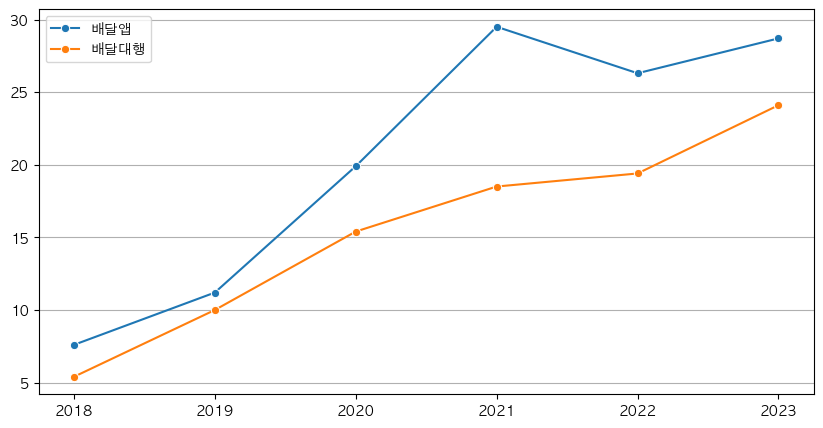

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

a = [7.6, 11.2, 19.9, 29.5, 26.3, 28.7]
b = [5.4, 10.0, 15.4, 18.5, 19.4, 24.1]

plt.figure(figsize=(10, 5))
rc('font', family='AppleGothic')
sns.lineplot(a, label='배달앱', marker='o')
sns.lineplot(b, label="배달대행", marker='o')
plt.xticks(np.arange(6), labels=['2018', '2019', '2020', '2021', '2022', '2023'])
plt.grid(axis='y')
plt.legend()
plt.show()